In [152]:
import numpy as np
import pr3_utils 
from pr3_torch_utils import *
from stereo import *
from tqdm import tqdm

In [153]:
dataset = "03"
features_sample_step = 100

time_stamp,features,linear_velocity,angular_velocity,K,b,imu_T_cam = \
    load_data_torch(f"../data/{dataset}.npz")


num_time_stamp = time_stamp.shape[0]
features = features[:, ::features_sample_step, :]
num_features = features.shape[1]

tau = (time_stamp[1:] - time_stamp[:-1]).to(dtype=DTYPE, device=DEVICE)
velocity = torch.concatenate([linear_velocity, angular_velocity], dim=1)

In [154]:
cam_T_imu = inversePose(imu_T_cam)
fsu = K[0,0]
fsv = K[1,1]
cu  = K[0,2]
cv  = K[1,2]
Ks = torch.tensor([
    [fsu,0,cu,0],
    [0,fsv,cv,0],
    [fsu,0,cu,-fsu*b],
    [0,fsv,cv,0],
],dtype=DTYPE, device=DEVICE)
P = torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
],dtype=DTYPE, device=DEVICE)

In [155]:
def odot(s):
    '''
    s: shape (4,)
    '''
    re = torch.zeros([4,6], dtype=s.dtype, device=s.device)
    re[:3,:3] = torch.eye(3)
    re[:3,3:] = axangle2skew(s[...,:3])
    return re

In [173]:
#noise model
W = 100*torch.eye(6, dtype=DTYPE, device=DEVICE)
V = 100

# log list
M_covar_norm_t = []
M_covar_norm = []

# init
T_mean = torch.zeros([num_time_stamp, 4, 4], 
                     dtype=DTYPE, device=DEVICE)
T_covar = torch.zeros([num_time_stamp, 6, 6], 
                     dtype=DTYPE, device=DEVICE)
M_mean = torch.from_numpy(np.load(f"../data/M_init_{dataset}.npy")[::features_sample_step, :])\
        .to(dtype=DTYPE, device=DEVICE)
covar_flat = V*torch.eye(num_features*3+6, num_features*3+6, 
                       dtype=DTYPE, device=DEVICE)
covar = covar_flat.view(num_features+2, 3, num_features+2, 3)
T_mean[0,:,:] = torch.tensor([
    [1, 0, 0,0],
    [0, 1, 0,0],
    [0, 0, 1,0],
    [0, 0, 0,1],
])


# EKF
for t in tqdm(range(1, num_time_stamp)):

    # predict step
    T_mean[t,:,:] = T_mean[t-1,:,:] @ twist2pose(tau[t-1]*axangle2twist(velocity[t]))
    F = twist2pose(-tau[t-1]*axangle2adtwist(velocity[t]))
    T_covar[t,:,:] = F @ T_covar[t-1,:,:] @ F.T + W
    covar_flat[-6:,-6:] = T_covar[t,:,:]
    
    # update step
    present_mask = get_seeing_mask_torch(features[t,:,:], d_min=5)
    Nt = int(torch.sum(present_mask))
    if Nt == 0:
        continue
    # compose observation
    present_M_mean = M_mean[present_mask, :]
    present_M_mean_homo = torch.hstack([present_M_mean, torch.ones([Nt,1],device=present_M_mean.device)])
    # build H
    H = torch.zeros([Nt, 4, num_features+2, 3], dtype=DTYPE, device=DEVICE)
    imu_T_world = inversePose(T_mean[t])
    cam_T_world = cam_T_imu @ imu_T_world
    i_list = torch.where(present_mask == True)[0].detach().cpu().tolist()
    for j, i in enumerate(i_list):
        # δh(T, m_j) / δm_j
        H[j,:,i,:] = Ks @ \
            projectionJacobian((cam_T_world @ present_M_mean_homo[[j],:].T).squeeze()) @ \
            cam_T_world @ P.T
        # δh(T, m_j) / δT
        H[j,:,-2:,:] =(-Ks @ \
            projectionJacobian((cam_T_world @ present_M_mean_homo[[j],:].T).squeeze()) @ \
            cam_T_imu @ odot((imu_T_world @ present_M_mean_homo[[j],:].T).squeeze())
        ).reshape(1,4,2,3)
    H = H.reshape([Nt*4, (num_features+2)*3])
    # compute Kalman gain and innovation 
    K = covar_flat @ H.T @ torch.linalg.inv(H @ covar_flat @ H.T + V*torch.eye(Nt*4,dtype=DTYPE,device=DEVICE))
    innovation = K @ (
        features[t,present_mask,:] - (projection(present_M_mean_homo @ cam_T_world.T)@Ks.T)
    ).reshape(-1)
    if torch.isnan(innovation).any():
        print("nan at", t)
        break
    innovation_M = innovation[:num_features*3]
    innovation_T = innovation[num_features*3:]
    # update
    M_mean = M_mean + innovation_M.reshape(-1, 3)
    T_mean[t,:,:] = T_mean[t,:,:] @ axangle2pose(innovation_T)
    covar_flat = (torch.eye((num_features+2)*3, dtype=DTYPE, device=DEVICE) - K@H) @ covar_flat
    
    # log covariance
    if t%50 == 0:
        M_covar_norm_t.append(time_stamp[t].item())
        M_covar_norm.append(torch.linalg.norm(covar).item())

  0%|          | 0/1009 [00:00<?, ?it/s]

  1%|          | 8/1009 [00:00<00:35, 28.13it/s]

nan at 9


In [174]:
present_mask

tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False], device='mps:0')

In [175]:
present_M_mean_homo[[j],:]

tensor([[ 35.6847, -33.2360, -10.3490,   1.0000]], device='mps:0')

In [179]:
Ks@projection(cam_T_world@present_M_mean_homo[j,:])

NameError: name 'cam_T_world' is not defined

In [162]:
features_to_PC_torch(features[10,0,:],K,b)

tensor([nan, nan, nan], device='mps:0')

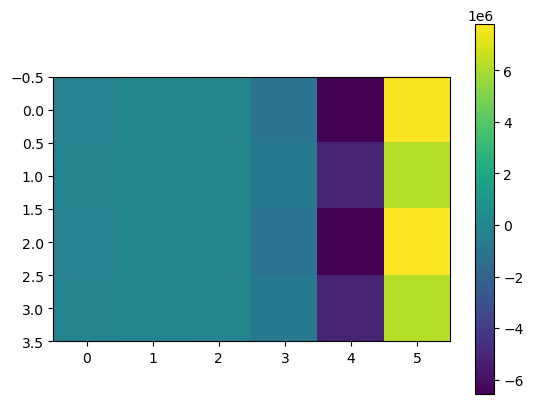

In [172]:
import matplotlib.pyplot as plt
plt.imshow((
    -Ks @ \
    projectionJacobian((cam_T_world @ present_M_mean_homo[[j],:].T).squeeze()) @ \
    cam_T_imu @ odot((imu_T_world @ present_M_mean_homo[[j],:].T).squeeze())
).cpu().numpy(), cmap='viridis')  # 'cmap' specifies the colormap
plt.colorbar()  # Adds a color bar to interpret the values
plt.show()

In [164]:
t = (H @ covar_flat @ H.T).cpu()

In [165]:
H

tensor([[ 1.4947e+05,  1.2662e+05,  6.2615e+04,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.

In [166]:
t

tensor([[1.0643e+14, 8.4652e+13, 1.0811e+14, 8.4652e+13],
        [8.4652e+13, 6.7440e+13, 8.5990e+13, 6.7440e+13],
        [1.0811e+14, 8.5990e+13, 1.0982e+14, 8.5990e+13],
        [8.4652e+13, 6.7440e+13, 8.5990e+13, 6.7440e+13]])

In [167]:
torch.linalg.inv(t)

_LinAlgError: linalg.inv: The diagonal element 4 is zero, the inversion could not be completed because the input matrix is singular.

In [ ]:
T_mean

tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 2.0000e+00,  1.4347e-03, -2.0278e-03,  7.0470e-02],
         [-1.4339e-03,  2.0000e+00,  8.0842e-04,  9.5581e-03],
         [ 2.0284e-03, -8.0687e-04,  2.0000e+00, -1.5953e-03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0000e+00]],

        [[ 3.0000e+00, -1.9883e-03, -7.1662e-03,  1.5716e-01],
         [ 2.0010e-03,  3.0000e+00,  4.8000e-03,  4.4355e-02],
         [ 7.1651e-03, -4.8025e-03,  3.0000e+00, -1.1075e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  3.0000e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,

TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


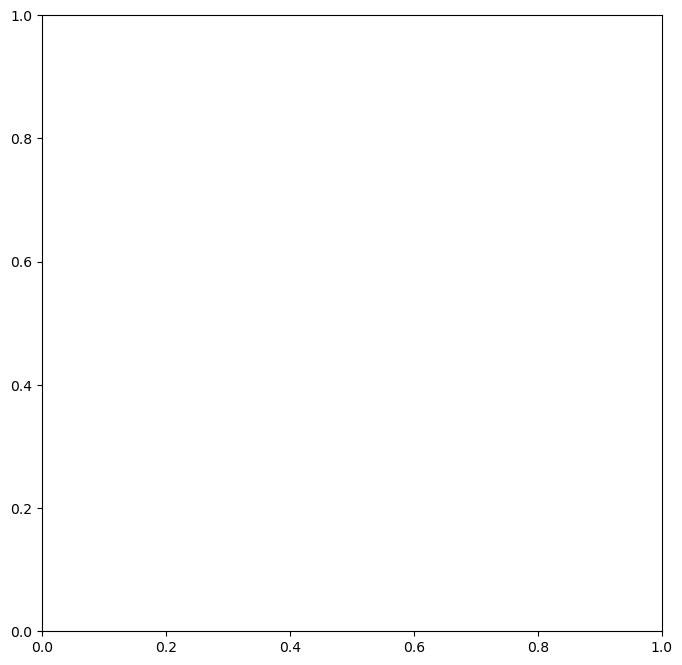

In [ ]:
fig,_ = pr3_utils.visualize_trajectory(T_mean, features=M_mean, show_ori=False, path_name="EKF_localization")
fig.savefig(f"../img/EKF_mapping_{dataset}", dpi=300)
plt.plot()

In [ ]:
mask = torch.tensor([True, False, True])

# Find the indices where the mask is True
true_indices = torch.where(mask)

# Iterate through all True indices
for j,i in enumerate(true_indices[0]):
    print(j,i)


0 tensor(0)
1 tensor(2)


(<Figure size 800x800 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

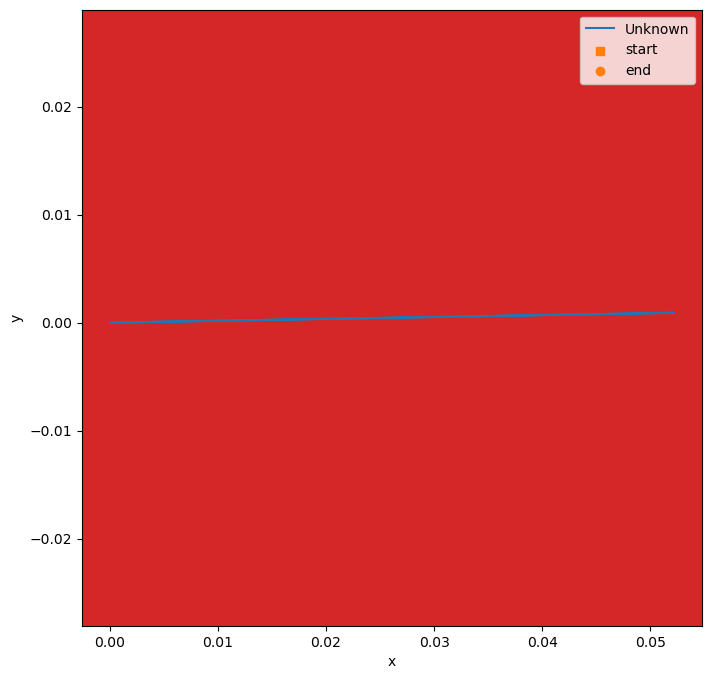

In [ ]:
pr3_utils.visualize_trajectory(T_mean.cpu().numpy(), T_sigma=T_covar.cpu().numpy(), show_ori=True, show_var=True, show_features=False)

In [ ]:
present_mask = torch.tensor([1, 1, 0], dtype=torch.bool)
d_mask = torch.tensor([1,0],dtype=torch.bool)
present_mask[present_mask.clone()] = d_mask
present_mask

tensor([ True, False, False])

In [ ]:
h = torch.arange(24, dtype=DTYPE, device=DEVICE)
j = h.view(4,6)

h, j

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23.], device='mps:0'),
 tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
         [ 6.,  7.,  8.,  9., 10., 11.],
         [12., 13., 14., 15., 16., 17.],
         [18., 19., 20., 21., 22., 23.]], device='mps:0'))

In [ ]:
h[0] = -1
j

tensor([[-1.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23.]], device='mps:0')